# APS360 Group Project

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from train import train_net, train_auto_encoder, init_device, test_net
from graph import plot_training_curve, generate_confusion_matrix, visualize_output, visualize_autoencoder_output

In [2]:
init_device()

Cuda Available: True


## Baseline Model

In [3]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__() 
        self.conv1 = nn.Conv2d(1, 5, 3) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.conv3 = nn.Conv2d(10, 20, 3)
        self.fc = nn.Linear(26*26*20, 10)

    def forward(self, x, training=False):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 26*26*20)

        x = self.fc(x)

        return x


In [4]:
# train_net(BaselineModel, "baseline_model", learning_rate=0.01, num_epochs=15)

## Primary Model

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # 32 x 112 x 112
        x = self.pool(F.relu(self.conv2(x)))    # 64 x 56 x 56
        x = self.pool(F.relu(self.conv3(x)))    # 128 x 28 x 28

        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.conv4 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.conv5 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.conv6 = nn.ConvTranspose2d(32, 1, 3, 2, 1, 1)

    def forward(self, x):

        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x)) 
        x = self.conv6(x)
        
        return x

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

class PrimaryModel(nn.Module):
    def __init__(self, encoder):
        super(PrimaryModel, self).__init__()
        self.encoder = encoder
        self.encoder.requires_grad_(False)

        self.conv = nn.Conv2d(128, 32, 1)
        
        self.fc1 = nn.Linear(32*28*28, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        
        x = self.encoder(x)
        x = F.relu(self.conv(x))
        
        x = x.view(-1, 32*28*28)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)

        return x

In [7]:
train_auto_encoder(AutoEncoder, "autoencoder", learning_rate=0.001, num_epochs=30, batch_size=16)

Done Loading Data
Starting Training
Epoch 1: Train loss: 0.053355649585525196 | Validation loss: 0.034823770314455035
Epoch 2: Train loss: 0.03215807460745176 | Validation loss: 0.028819429472088813
Epoch 3: Train loss: 0.027118553010125956 | Validation loss: 0.025919458642601968
Epoch 4: Train loss: 0.02514015749345223 | Validation loss: 0.02434927047789097
Epoch 5: Train loss: 0.023914805899063748 | Validation loss: 0.023458177775144577
Epoch 6: Train loss: 0.023080440364778042 | Validation loss: 0.02282618084549904
Epoch 7: Train loss: 0.022455874189734458 | Validation loss: 0.02233493708819151
Epoch 8: Train loss: 0.021868942119181157 | Validation loss: 0.021777570091187953
Epoch 9: Train loss: 0.021447092910607656 | Validation loss: 0.021261325016617774
Epoch 10: Train loss: 0.021033269663651783 | Validation loss: 0.020965698041021823
Epoch 11: Train loss: 0.020713186326126256 | Validation loss: 0.020638782396912574
Epoch 12: Train loss: 0.020457539834082127 | Validation loss: 0.0

In [8]:

auto_encoder = AutoEncoder()
auto_encoder.load_state_dict(torch.load("autoencoder\\best_model"))
train_net(PrimaryModel, "primary_model", encoder=auto_encoder.encoder, learning_rate=0.001, num_epochs=30, batch_size=32)

Done Loading Data
Starting Training
Epoch 1: Train err: 0.7695, Train loss: 2.206915003188113 | Validation err: 0.652, Validation loss: 2.121763242615594
Epoch 2: Train err: 0.5761666666666667, Train loss: 2.0478528160998164 | Validation err: 0.531, Validation loss: 2.0086221146205117
Epoch 3: Train err: 0.478, Train loss: 1.9534630471087517 | Validation err: 0.4585, Validation loss: 1.9232091222490584
Epoch 4: Train err: 0.3955, Train loss: 1.868444600637923 | Validation err: 0.4025, Validation loss: 1.8705064455668132
Epoch 5: Train err: 0.3443333333333333, Train loss: 1.8204997372119984 | Validation err: 0.3745, Validation loss: 1.8459466657941304
Epoch 6: Train err: 0.2768333333333333, Train loss: 1.7508925605327526 | Validation err: 0.3395, Validation loss: 1.806037427887084
Epoch 7: Train err: 0.2678333333333333, Train loss: 1.739378515710222 | Validation err: 0.4035, Validation loss: 1.8630862027879744
Epoch 8: Train err: 0.24983333333333332, Train loss: 1.7192970786957031 | Val

KeyboardInterrupt: 

# Visualization

In [6]:
# Testing
print("Baseline Model: ", end="")
test_net(BaselineModel, "baseline_model\\best_model")
print("Primary Model: ", end="")
test_net(PrimaryModel, "primary_model\\best_model", encoder_class=Encoder)

Baseline Model: Done Loading Data
Test error: 0.105, Test loss: 0.4006997002288699
Primary Model: Done Loading Data
Test error: 0.3585, Test loss: 1.817328803241253


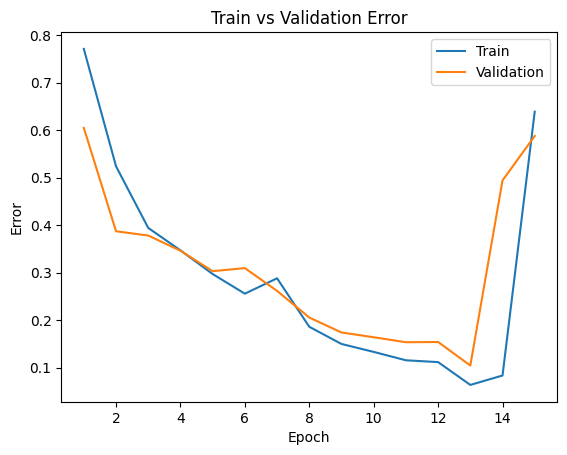

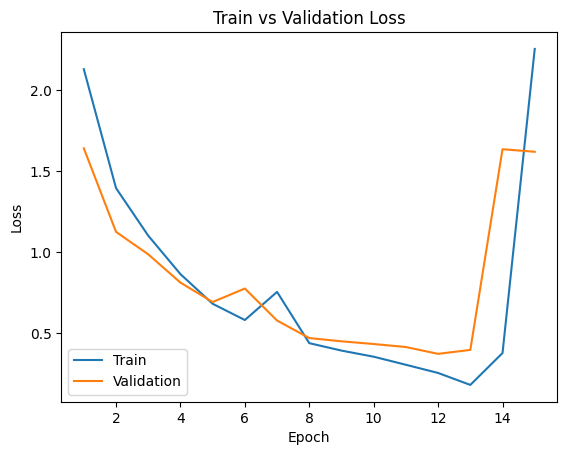

FileNotFoundError: primary_model/train_err.csv not found.

In [9]:
# Graphing
plot_training_curve("baseline_model")
plot_training_curve("primary_model")

Done Loading Data


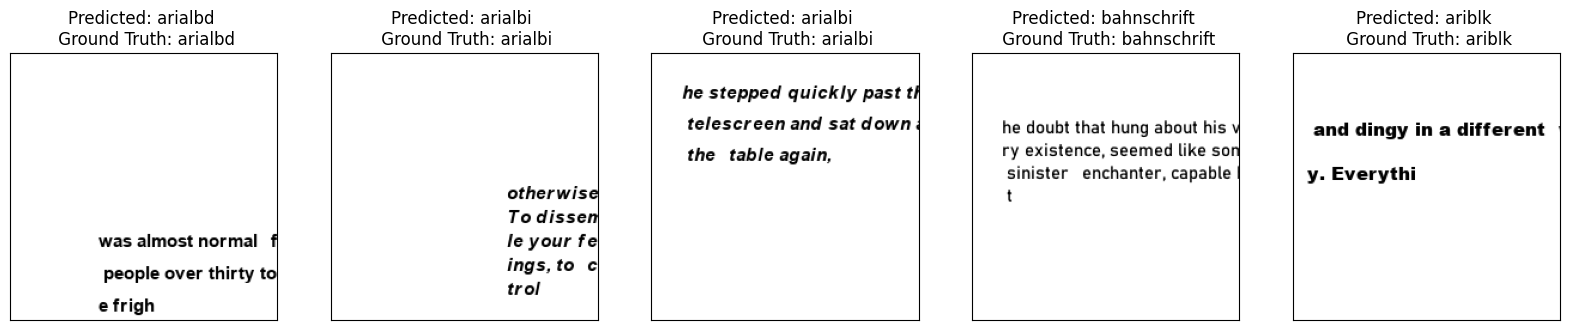

Done Loading Data


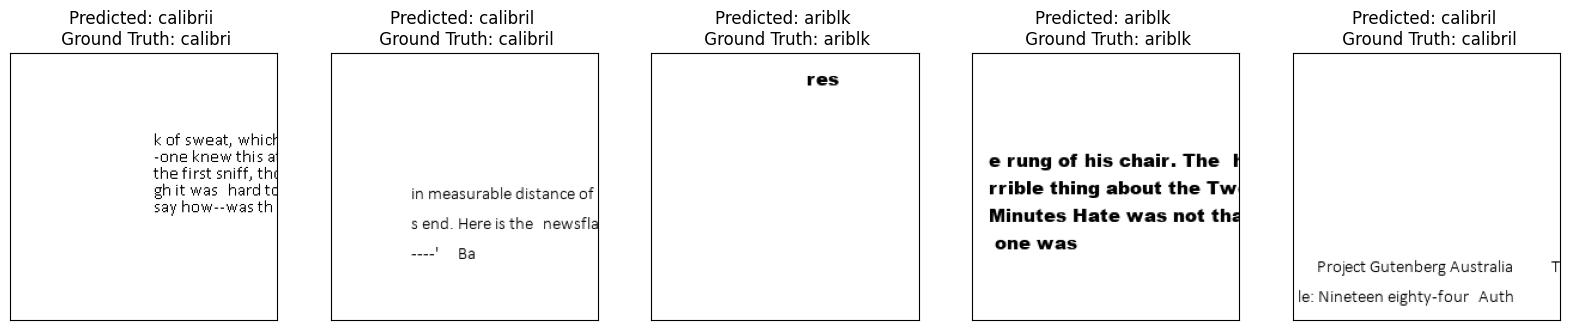

In [6]:
# Visualizing
visualize_output(5 ,"baseline_model\\best_model", BaselineModel)
visualize_output(5, "primary_model\\best_model", PrimaryModel, encoder_class=Encoder)

Done Loading Data


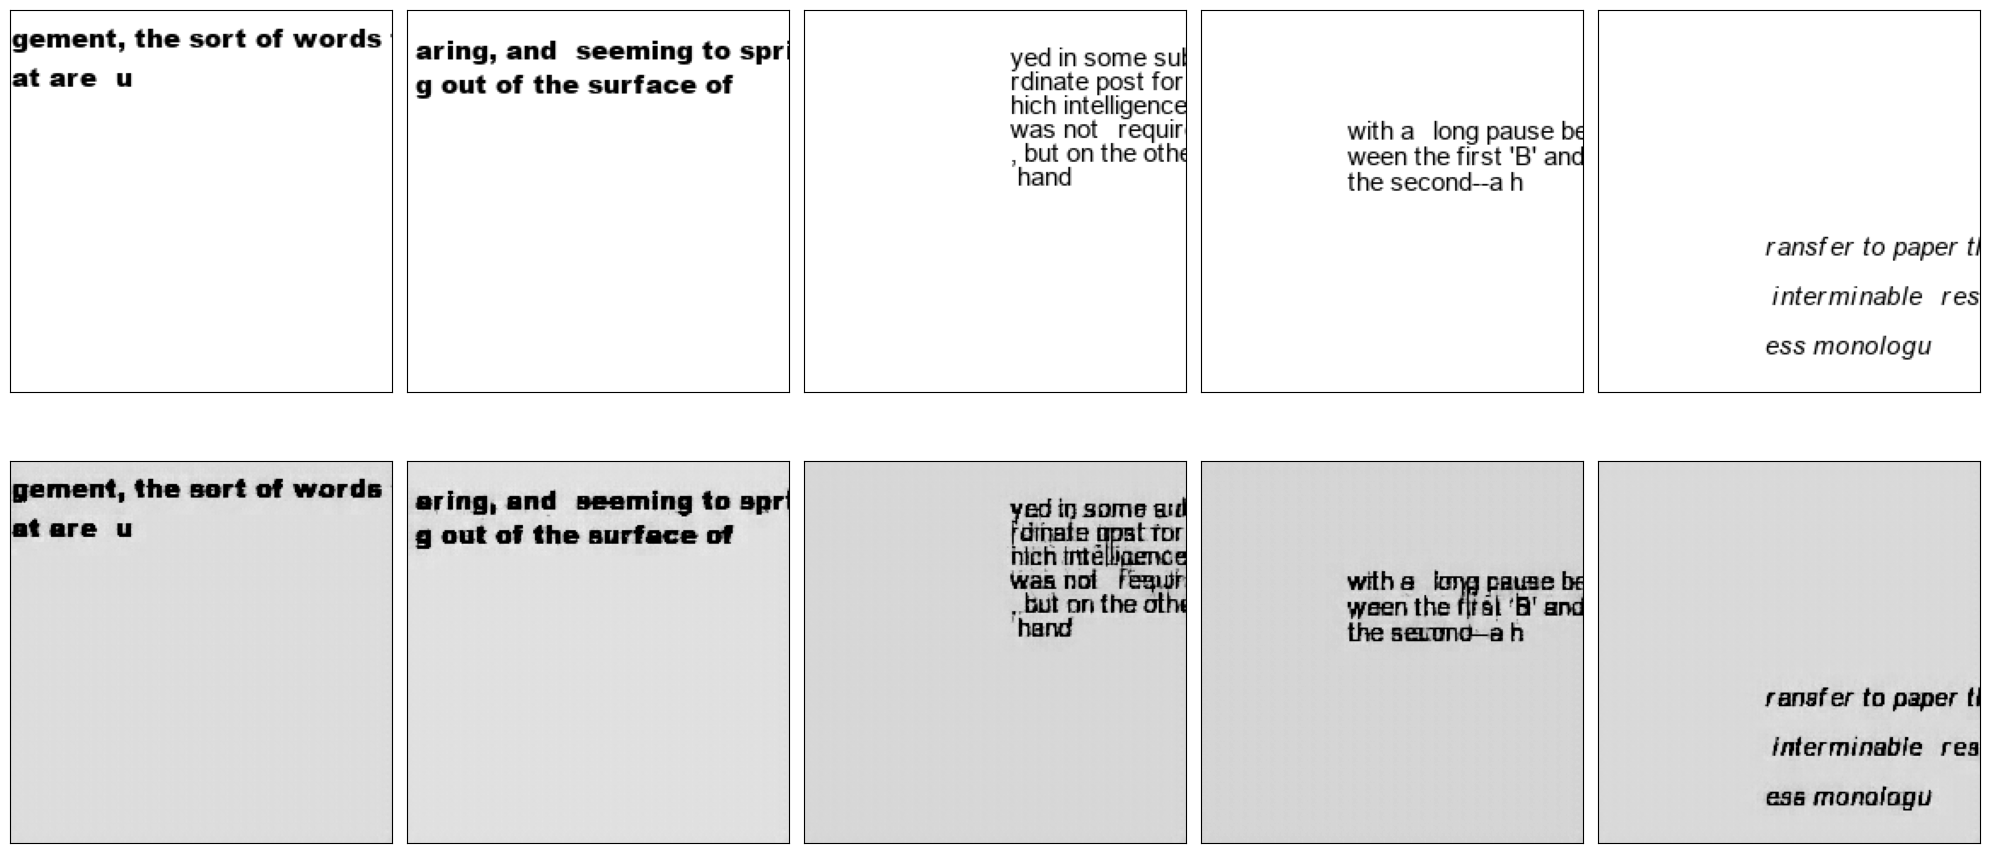

In [4]:
visualize_autoencoder_output(5, "autoencoder\\best_model", AutoEncoder)


In [ ]:
# Confusion Matrix
generate_confusion_matrix(BaselineModel, "baseline_model\\best_model")
generate_confusion_matrix(PrimaryModel, "primary_model\\best_model")